In [1]:
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import itertools as it
from tqdm.notebook import tqdm

In [2]:
import seaborn as sns
%pylab inline
sns.set()

Populating the interactive namespace from numpy and matplotlib


In [3]:
import numba

In [4]:
def invboxcox(y, lmbda):
    if lmbda == 0:
        return(np.exp(y))
    
    else:
        return(np.exp(np.log(lmbda*y + 1) / lmbda))

In [5]:
# pd.read_excel?

In [6]:
crime = pd.read_excel('crime.xlsx', sheet_name='pandas')
crime.set_index(pd.to_datetime(crime.month), inplace=True)
crime.drop(['month'], axis=1, inplace=True)
crime

,Total_crimes,Serious_and_especially_serious,Causing_huge_damage,Ecological,Terrorism,Extremism,Murder,Serious_harm_to_health,Rape_assault,Razboy,Grabezh,Theft,Vehicle_theft,Fraud_scam,Hooligan,Drugs,Weapons
month,,,,,,,,,,,,,,,,,
2003-01-01,214587,88203,20162,1216,630,13,2749,5559,574,3698,16455,81014,3549,7731,10560,16006,4661
2003-02-01,221928,88863,20889,1701,678,5,2444,4732,515,3678,15724,95970,3697,7607,10816,16839,5364
2003-03-01,248452,101349,24053,1817,809,10,2864,4851,560,4406,15674,79420,4327,9437,11813,20176,5938
2003-04-01,236299,91625,19754,2449,892,10,2919,4722,668,4322,14440,95215,5345,7824,12636,16614,5230
2003-05-01,230931,89615,17519,3530,796,20,2713,4895,688,3781,14209,94505,6374,7122,12234,14413,5112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-09-01,166208,38967,64283,1858,122,48,555,1570,306,537,3612,67006,1903,21557,155,15100,1945
2019-10-01,199038,53319,81775,2322,111,52,668,1846,223,652,3984,81053,2197,27980,180,20510,1744
2019-11-01,148104,31652,49623,1581,149,27,622,1467,246,507,3403,57434,1344,19794,132,11067,1742


## Будем рассматривать данные по убийствам

In [7]:
CATEGORY = 'Murder'

In [8]:
data = crime[[CATEGORY]]
data.columns = ['amount']
data['amount'] = data.amount.astype(float)
data

,amount
month,
2003-01-01,2749.0
2003-02-01,2444.0
2003-03-01,2864.0
2003-04-01,2919.0
2003-05-01,2713.0
...,...
2019-09-01,555.0
2019-10-01,668.0
2019-11-01,622.0


### Строим график

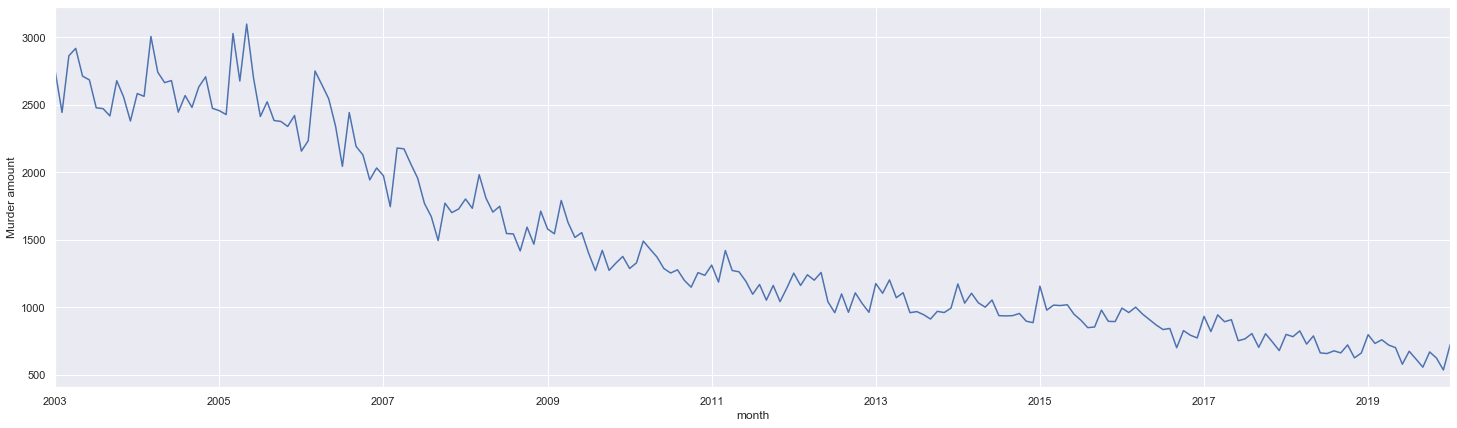

Стандартное отклонение: 687.71


In [9]:
plt.figure(figsize(25, 7))
data.amount.plot()
plt.ylabel(f'%s amount' % CATEGORY)
plt.show()

print('Стандартное отклонение: %.2f' % data.amount.std())

### Проверка стационарности и STL-декомпозиция ряда:

<Figure size 1080x720 with 0 Axes>

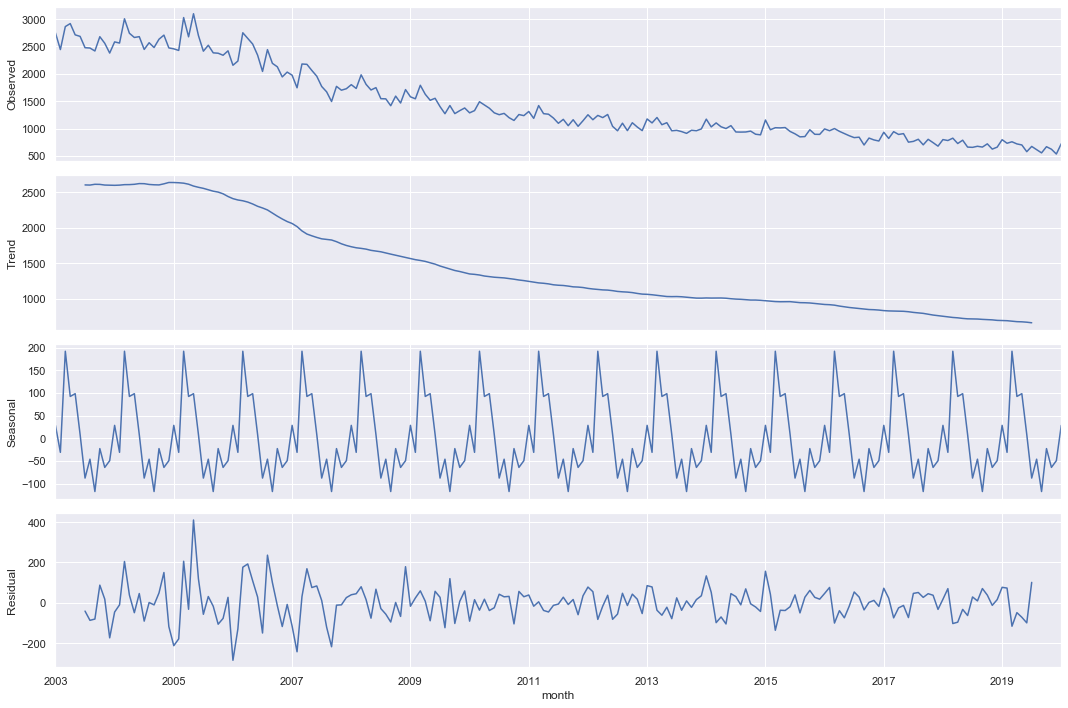

Критерий Дики-Фуллера: p = 0.260153


In [10]:
plt.figure(figsize(15, 10))
sm.tsa.seasonal_decompose(data.amount).plot()
plt.show()

print("Критерий Дики-Фуллера: p = %f" % sm.tsa.stattools.adfuller(data.amount)[1])

Смотрим на значение $p_{value} = 0.26$ критерия Дики-Фуллера:
* $p_{value} \ll 0.05$ => гипотеза нестационарности ряда отвергается
* $p_{value} \gg 0.05$ => есть основания не отвергать гипотезу нестационарности

Сразу видны следующие особенности данных:
* убывающий тренд
* Падающая со временем дисперсия, но все равно довольно большая
* периодичность (период = 12 месяцев)
* Остатки вроде бы не имеют структуры

In [11]:
season = 12

### Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

In [12]:
NEED = True

In [13]:
if NEED:
    data['amount_boxcox'], lmbda = stats.boxcox(data.amount)
else:
    data['amount_boxcox'], lmbda = data.amount, 1

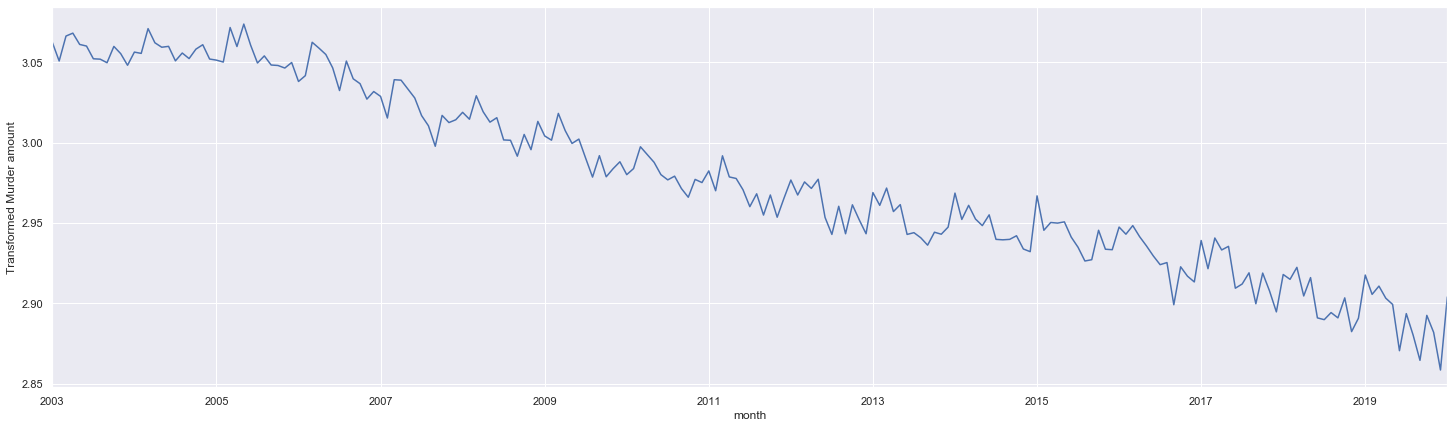

Оптимальный параметр преобразования Бокса-Кокса: -0.294960
Критерий Дики-Фуллера: p = 0.959568


In [14]:
plt.figure(figsize(25, 7))
data.amount_boxcox.plot()
plt.ylabel('Transformed %s amount' % CATEGORY)
plt.show()

print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p = %f" % sm.tsa.stattools.adfuller(data.amount_boxcox)[1])

In [15]:
print('Стандартное отклонение: %.2f' % data.amount_boxcox.std())

Стандартное отклонение: 0.06


Размах дисперсии ощутимо уменьшился.

Смотрим на значение $p_{value} = 0.96$ критерия Дики-Фуллера:
* $p_{value} \ll 0.05$ => гипотеза нестационарности ряда отвергается
* $p_{value} \gg 0.05$ => есть основания не отвергать гипотезу нестационарности

### Стационарность

Критерий Дики-Фуллера не отвергает гипотезу нестационарности, и визуально в данных виден тренд. Попробуем сначала ***сезонное дифференцирование*** и позже сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

<Figure size 1080x720 with 0 Axes>

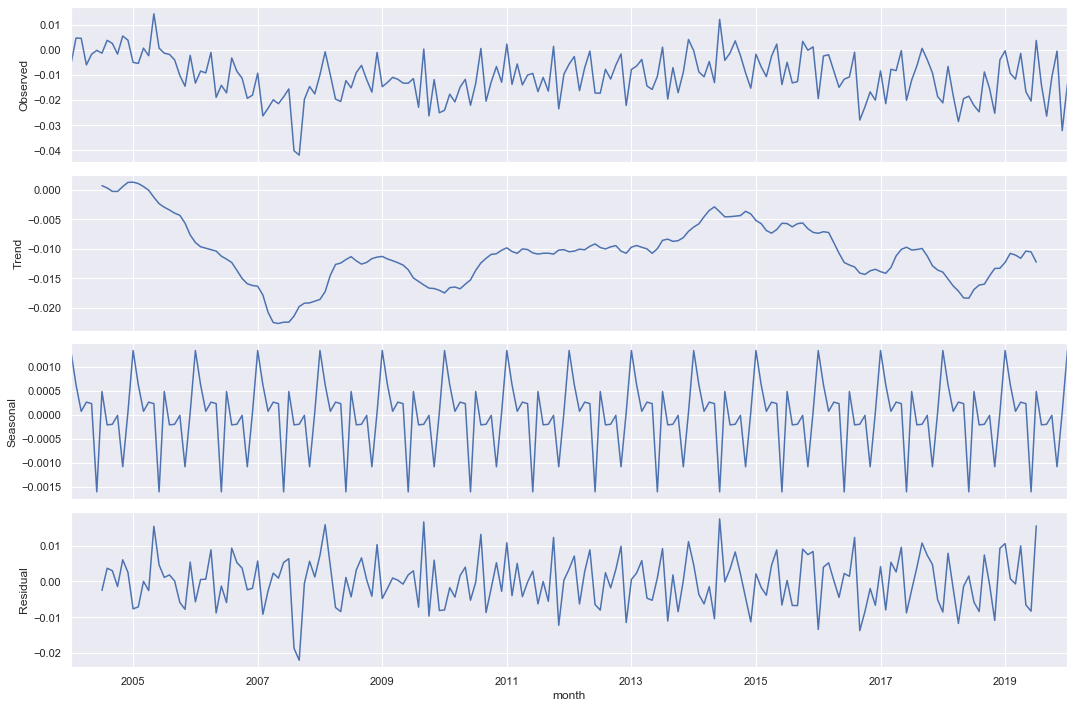

Критерий Дики-Фуллера: p = 0.062619


In [16]:
data['amount_boxcox_diff'] = data.amount_boxcox - data.amount_boxcox.shift(season)

plt.figure(figsize(15, 10))
sm.tsa.seasonal_decompose(data.amount_boxcox_diff[season:]).plot()
plt.show()

print("Критерий Дики-Фуллера: p = %f" % sm.tsa.stattools.adfuller(data.amount_boxcox_diff[season:])[1])

Смотрим на значение $p_{value} = 0.06$ критерия Дики-Фуллера:
* $p_{value} \ll 0.05$ => гипотеза нестационарности отвергается
* $p_{value} \gg 0.05$ => есть основания не отвергать гипотезу нестационарности

Применяем ***обычное дифференцирование***

<Figure size 1080x720 with 0 Axes>

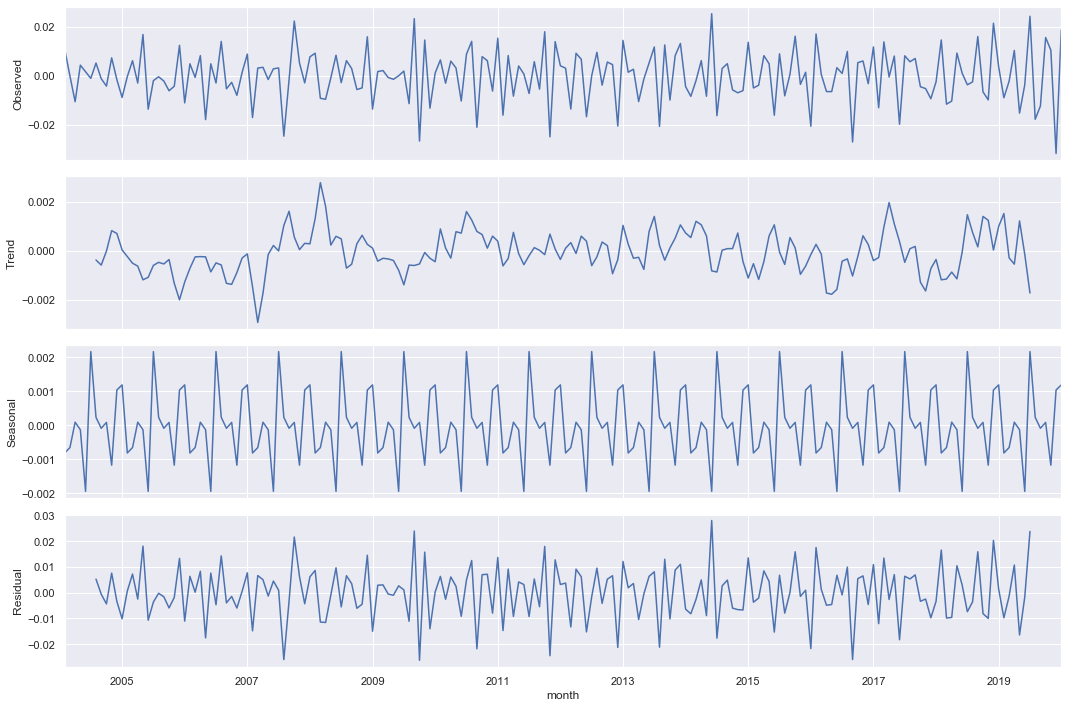

Критерий Дики-Фуллера: p = 0.000002


In [17]:
data['amount_boxcox_diff2'] = data.amount_boxcox_diff - data.amount_boxcox_diff.shift(1)

plt.figure(figsize(15, 10))
sm.tsa.seasonal_decompose(data.amount_boxcox_diff2[season + 1:]).plot()
plt.show()

print("Критерий Дики-Фуллера: p = %f" % sm.tsa.stattools.adfuller(data.amount_boxcox_diff2[season + 1:])[1])

Смотрим на значение $p_{value} = 0.00$ критерия Дики-Фуллера:
* $p_{value} \ll 0.05$ => гипотеза нестационарности ряда отвергается
* $p_{value} \gg 0.05$ => есть основания не отвергать гипотезу нестационарности ряда

## Подбор модели

Посмотрим на ACF и PACF полученного ряда:

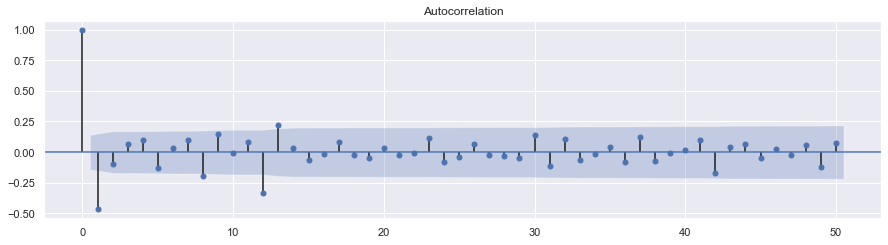

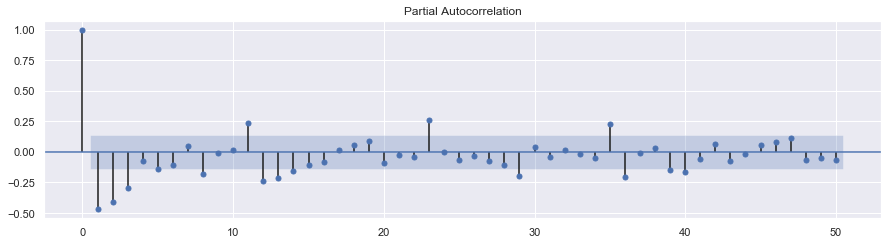

In [18]:
plt.figure(figsize(15, 8))

ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(
    data.amount_boxcox_diff2[season + 1:].values.squeeze(),
    lags=50,
    ax=ax)
plt.show()

ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(
    data.amount_boxcox_diff2[season + 1:].values.squeeze(),
    lags=50,
    ax=ax)
plt.show()

$Q = 1$ - последний значимый лаг, кратный сезонности<br>
$q = 8$ - последний значимый лаг на ACF, меньший чем значение сезонности<br>
$P = 3$ - последний значимый лаг, кратный сезонности<br>
$p = 11$ - последний значимый лаг на PACF, меньший чем значение сезонности<br>

In [19]:
Qs = range(0, 2)
qs = range(0, 9)

Ps = range(0, 4)
ps = range(0, 12)

D = 1
d = 1

In [20]:
parameters = it.product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

864

#### Запускаем в работу нашу модель

Возможны какие-то ошибки, решаем их таким образом:
* либо добавляем их в исключения *(позже пожалею об этом)*


* либо добавляем параметры в `SARIMAX` модель (от этого может стать хуже модель)
    * можно попробовать `enforce_stationarity=False`
    * можно еще `initialization='approximate_diffuse'`

In [21]:
def optimizeSARIMA(parameters_list, d, D, season):
    '''
    Returns a dataframe with parameters for SARIMA model and corresponding by AIC
    
    parameters_list - list with (p, q, P, Q) tuples
    d - diff order in ARIMA model
    D - seasonal diff order
    season - length of season
    '''
    results = []
    best_aic = float('inf')
    
    warnings.filterwarnings('ignore')
    
    for param in tqdm(parameters_list):
        # try except нужен, потому что на некоторых наборах параметров модель не обучается
        # или просто кидает ошибку типа LinAlgError или ValueError
        try:
            model = sm.tsa.statespace.SARIMAX(data.amount_boxcox, 
                                              order=(param[0], d, param[1]), 
                                              seasonal_order=(param[2], D, param[3], season)).fit(disp=-1)
        # выводим параметры, на которых модель не обучается и переходим к следующему набору
        except:
            print('применен костыль', param)
            model = sm.tsa.statespace.SARIMAX(data.amount_boxcox, 
                                              order=(param[0], d, param[1]), 
                                              seasonal_order=(param[2], D, param[3], season), 
                                              initialization='approximate_diffuse').fit(disp=-1)
            
        aic = model.aic        
        results.append([param, aic])
    
    warnings.filterwarnings('default')
    
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # сортируем в возрастающем порядке, чем меньше AIC, тем лучше
    result_table = result_table.sort_values(by = 'aic', ascending=True).reset_index(drop=True)
    
    return result_table
    

In [22]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, season)

применен костыль (0, 4, 2, 1)
применен костыль (1, 6, 1, 1)
применен костыль (2, 3, 3, 0)
применен костыль (4, 8, 0, 1)
применен костыль (7, 7, 1, 1)

Wall time: 1h 36min 50s


#### Выводим удачные модели:

In [24]:
result_table.head()

,parameters,aic
0,"(2, 1, 0, 1)",-1340.808347
1,"(3, 3, 0, 1)",-1340.743516
2,"(2, 1, 1, 1)",-1339.816340
3,"(0, 2, 0, 1)",-1339.365912
4,"(0, 1, 1, 1)",-1339.023704


#### Лучшая модель:

In [25]:
# если не обучал модель, то используй готовые параметры
best_param = (2, 1, 0, 1)
D = 1
d = 1

In [26]:
# если обучал модель
best_param = result_table.parameters[0]
best_param

(2, 1, 0, 1)

In [27]:
best_model = sm.tsa.statespace.SARIMAX(data.amount_boxcox, 
                                              order=(best_param[0], d, best_param[1]), 
                                              seasonal_order=(best_param[2], D, best_param[3], season)).fit(disp=-1)
print(best_model.summary())

C:\Users\tsark\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                      amount_boxcox   No. Observations:                  205
Model:             SARIMAX(2, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 675.404
Date:                            Thu, 02 Apr 2020   AIC                          -1340.808
Time:                                    13:14:54   BIC                          -1324.521
Sample:                                01-01-2003   HQIC                         -1334.212
                                     - 01-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1537      0.113     -1.361      0.174      -0.375       0.068
ar.L2         -0.1480      0.099   

Рассмотрим остатки модели:

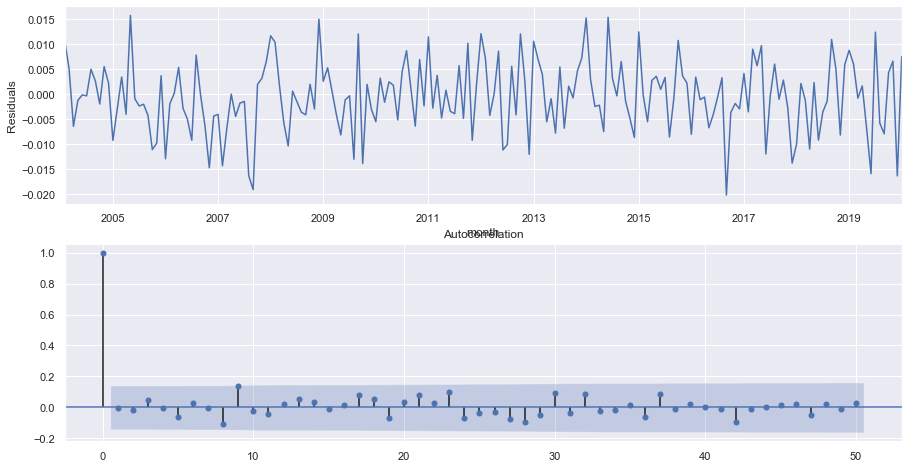

Критерий Стьюдента: p = 0.301446
Критерий Дики-Фуллера: p = 0.000000


In [28]:
plt.figure(figsize(15, 8))
plt.subplot(211)
best_model.resid[season + 1:].plot()
plt.ylabel('Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[season + 1:].values.squeeze(), lags=50, ax=ax)
plt.show()

print("Критерий Стьюдента: p = %f" % stats.ttest_1samp(best_model.resid[season + 1:], 0)[1])
print("Критерий Дики-Фуллера: p = %f" % sm.tsa.stattools.adfuller(best_model.resid[season + 1:])[1])

* Критерий Льюнга-Бокса: $p_{value} = 0.90 \gg 0.05$  - **остатки неавтокоррелированы**
* Критерий Стьюдента: $p_{value} = 0.30 \gg 0.05$ - **остатки несмещены**
* Критерий Дики-Фуллера: $p_{value} = 0.00 \ll 0.05$ - **остатки стационарны**

Продемонстрируем как работает наша модель

In [29]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda)

C:\Users\tsark\Anaconda3\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\tsark\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


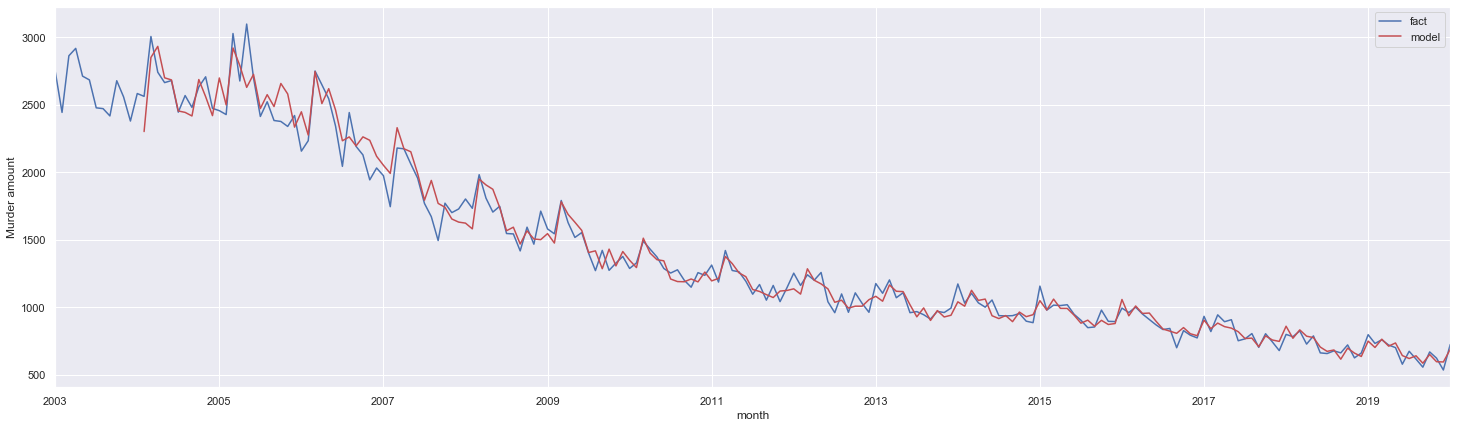

In [30]:
plt.figure(figsize(25, 7))
data.amount.plot(color='b', label='fact')
data.model[season + 1:].plot(color='r', label='model')
plt.ylabel('%s amount' % CATEGORY)
plt.legend()
plt.show()

#### Средняя ошибка аппроксимации

In [31]:
def mape(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [32]:
# я не буду учитывать первые 12 значений, потому что они заведомо сильно различаются,
# так как на них модель подбирает первые параметры
print('Средняя ошибка аппроксимации: %.2f%%' % mape(data.amount[season + 1:], data.model[season + 1:]))

Средняя ошибка аппроксимации: 4.66%


## Прогноз

Перед тем как прогнозировать, узнаем количество записей в `data` и также последнюю дату, от неё и прогнозируем

In [33]:
data2 = data[['amount']]
count = data2.shape[0] - 1
how_much = 12

In [34]:
date_list = [datetime.datetime.strptime("2020-01-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(how_much)]
future = pd.DataFrame(index=date_list, columns= data2.columns)

In [35]:
data2 = pd.concat([data2, future])
data2['forecast'] = invboxcox(best_model.predict(start=count, end=count+how_much), lmbda)

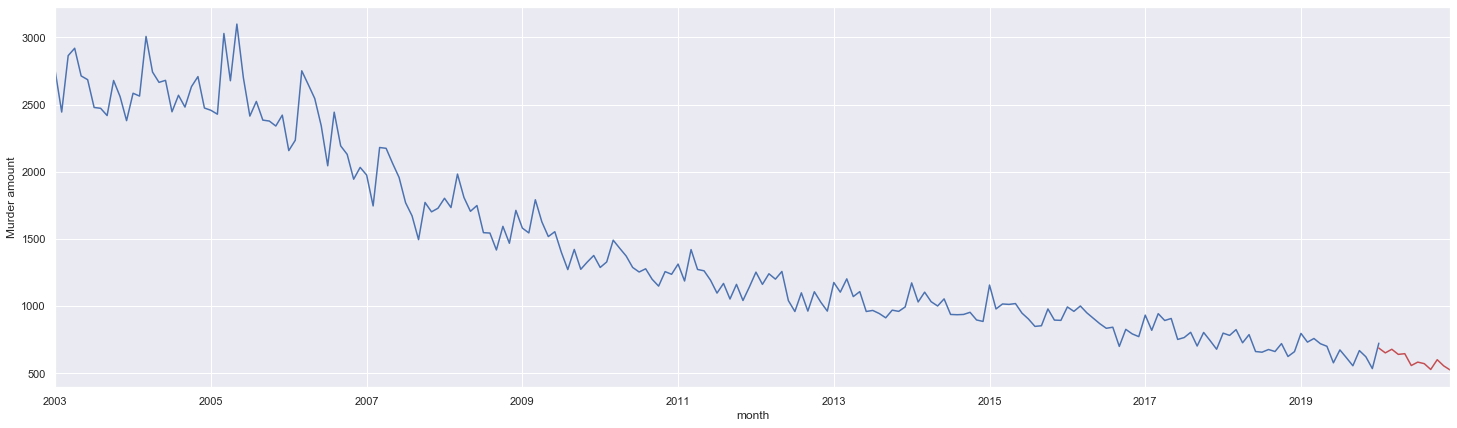

In [36]:
plt.figure(figsize(25, 7))
data.amount.plot(color='b')
data2.forecast.plot(color='r')
plt.ylabel('%s amount' % CATEGORY)
plt.show()

In [37]:
data2[['forecast']].tail(how_much)

,forecast
2020-01-01,686.595539
2020-02-01,650.981949
2020-03-01,677.792715
2020-04-01,639.689745
2020-05-01,644.937580
2020-06-01,556.753277
2020-07-01,582.174004
2020-08-01,570.807501
2020-09-01,527.413164
2020-10-01,600.045622
